In [ ]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));
push!(LOAD_PATH, "../src");

In [ ]:
#nbx
using BenchmarkTools;
using Colors, Plots;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using GridSlam
using Geometry
using MyUtils
include("src/sensor_b.jl");

In [ ]:
unstack(x::Matrix) = [x[i,:] for i=1:size(x,1)]
argdiffs(bs::Array{T,1}) where T <: Real = Tuple(map(b -> Bool(b) ? UnknownChange() : NoChange(), bs));

In [ ]:
include("src/csail_data.jl")

In [ ]:
_zmax

## Plotting

In [ ]:
function Plots.plot!(p::Pose; r=0.5, args...)
    plot!([p.x, p.x + r*unit_vec(p.hd)]; args...)
end

function Plots.plot!(ps::Vector{Pose}, cs::Vector{RGBA{Float64}}; r=0.5, args...)
    myplot=nothing
    for (p,c) in zip(ps,cs)
        myplot = plot!([p.x, p.x + r*unit_vec(p.hd)];c=c, args...)
    end
    return myplot
end

function Plots.plot!(ps::Vector{Pose}; r=0.5, args...)
    myplot=nothing
    for p in ps
        myplot = plot!([p.x, p.x + r*unit_vec(p.hd)]; args...)
    end
    return myplot
end

## Distributions we need

In [ ]:
#nbx
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src")
using GenDistributionZoo: ProductDistribution, diagnormal

mvuniform = ProductDistribution(uniform);
mvuniform(zeros(2), ones(2))

## Model parts

### Motion model

In [ ]:
#nbx --fname="src/motion_model.jl"
"""
    p′ = motion_model(p, u, x_noise=0.25, hd_noise=22.5)

Sample a new pose `p′` given the previous pose `p`, 
some control data `u = Control(dx, dhd)`, and noise levels
`x_noise` and `hd_noise` (in degrees).
"""
@gen function motion_model(p, u, x_noise=0.25, hd_noise=45/360*2π)
    dx, dhd = u.dx, u.dhd
    x   ~ diagnormal(p.x  + dx , [x_noise, x_noise])
    hd  ~ normal(p.hd + dhd, hd_noise)
    return p = Pose(x, hd)
end;

### Sensor model

In [ ]:
#nbx
as_ = CuArray(_as)

@gen function sensor_model_cu(p, ys, w, s_noise, outlier, outliver_vol=1.0)
    p_  = CuArray(Vector(p))
    ps_ = reshape(p_, 1, 3)
    ys_ = CuArray(stack(ys))

    zs_ = cast_cu(ps_, ys_; fov=π, zmax=100.0, cell_rad=0.01)
    
    y_tilde_ = get_ys_tilde_cu(zs_, as_, w)[1,:,:,:]
    x ~ sensordist_cu(y_tilde_, s_noise, outlier, outliver_vol)
    
    return x
end

In [ ]:
w            = 20
s_noise      = 0.2
outlier      = 0.1
outliver_vol = 1.0

t = 1_051
# p = Pose(1,3,4)
p = Pose(0,0,π/10)

@time x = sensor_model_cu(p, _ys[t], w, s_noise, outlier, outliver_vol)

# -------------------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
scatter!(x, c=col[1], alpha=0.5)
# scatter!(_ps[t], c=col[1])

## Step Model

In [ ]:
@gen function step_model(y, u, x_noise, hd_noise, w, s_noise, outlier, outliver_vol)
    
        p  = {:pose}   ~ motion_model(Pose(), u, x_noise, hd_noise)
        x  = {:sensor} ~ sensor_model_cu(p, y, w, s_noise, outlier, outliver_vol)
        
    return (p, x)
end

In [ ]:
get_pose(tr) = tr[][1]

In [ ]:
#nbx
function constraints(t::Int)
    ch = choicemap((:sensor => :x) => _ys[t])
    return ch
end

In [ ]:
N = 1_000


s = 4
i = 4
t = 1_050 + i*s

t2 = t + s

y   = _ys[t]
ux  = sum([u.dx  for u in _us[t:t+s-1]])
uhd = sum([u.dhd for u in _us[t:t+s-1]])
u = Control( rot(-_hds[t])*ux, uhd)
# u = _us[t]

ch = choicemap()
ch[:sensor => :x] = _ys[t+s]

println(u)

x_noise  = 0.4
hd_noise = 10/360*2π

w           = 25
s_noise     = 0.1
outlier     = 1e-3
outlier_vol = 1.0

args = (y, u, x_noise, hd_noise, w, s_noise, outlier, outliver_vol)
@time trs, ws, lml = importance_sampling(step_model, args, ch, N);

perm = sortperm(ws)
trs = trs[perm]
ws  = ws[perm];
scores = get_score.(trs);

plot(ws, size=(200,100))
plot!(scores, size=(200,100))

In [ ]:
ps = get_pose.(trs)
cs = cgrad(:viridis)[peak_to_peak(ws)]
# ------------------
mypl = plot(legend=nothing, aspect_ratio=:equal, title="w=$(w) - s_noise=$(s_noise) - outl.=$(outlier)")
plot!(ps, cs, linewidth=3)
scatter!(_ys[t], markersize=6, markerstrokewidth=0, c=col[1])
# scatter!(_ys[t], markersize=6, markerstrokewidth=0, c=:white)
scatter!(_ys[t+s].*ps[end], markersize=3, markerstrokewidth=0, c=:magenta)
mypl

In [ ]:
ps = []
xs = []
ts = []
for i=1:30
    N = 2_000

    s = 4
#     t = 1_050 + i*s
    t = 1_110 + i*s


    t2 = t + s

    y   = _ys[t]
    ux  = sum([u.dx for u in _us[t:t+s-1]])
    uhd = sum([u.dhd for u in _us[t:t+s-1]])
    u = Control( rot(-_hds[t])*ux, uhd)

    ch = choicemap()
    ch[:sensor => :x] = _ys[t+s]


    x_noise  = 0.4
    hd_noise = 10/360*2π

    w           = 25
    s_noise     = 0.05
    outlier     = 1e-3
    outlier_vol = 1.0

    args = (y, u, x_noise, hd_noise, w, s_noise, outlier, outliver_vol)
    @time trs, ws, lml = importance_sampling(step_model, args, ch, N);

    perm   = sortperm(ws)
    trs    = trs[perm]
    ws     = ws[perm];
    scores = get_score.(trs);

    tr = trs[end]
    push!(ps, tr[][1])
    push!(xs, tr[][2])
    push!(ts, t)
end

In [ ]:
p_ref = Pose()
qs = Pose[]

for p in ps
    push!(qs, p*p_ref)
    p_ref = p*p_ref
end

mypl = plot(aspect_ratio=:equal, legend=nothing)
plot!(qs, c=:red)
# scatter!(_ys[1050], markersize=6, markerstrokewidth=0, c=col[1])
for (x,q) in zip(xs, qs)
    scatter!(x.*q, markersize=1, markerstrokewidth=0, c=col[1])
end
mypl

In [ ]:
length(ts)

In [ ]:
plts = []
for (t,x,p) in zip(ts,xs,ps)
    # ------------------
    mypl = plot(size=(200,200), legend=nothing, aspect_ratio=:equal, title="t=$(t)")
    scatter!(_ys[t], markersize=4, markerstrokewidth=0, c=col[1])
    scatter!(x.*p, markersize=2, markerstrokewidth=0, c=:magenta)
    push!(plts,mypl)
end

plot(plts..., layout=(6,5), size=(1_000,1_000))

In [ ]:
using Fmt
nice_f(x) = f"{$x:0.2f}"
nice_f(0.123)

## SMC grid proposal

### Pose grid

In [ ]:
dx  = 0.1
dhd = 0.1
k = 3
collect(range(-dx*(k-1)/2, dx*(k-1)/2, k))

In [ ]:
#nbx
"""
    ps_ = pose_grid(p, k, dx, dhd)

Returns CuArray of pose vectors (k^3, 3).
"""
function pose_grid(p, k, dx, dhd)

#     dx1_ = CUDA.collect(CUDA.range(- dx*(k-1)/2,  dx*(k-1)/2, k))
#     dx2_ = CUDA.collect(CUDA.range(- dx*(k-1)/2,  dx*(k-1)/2, k))
#     dhd_ = CUDA.collect(CUDA.range(-dhd*(k-1)/2, dhd*(k-1)/2, k))
    dx1_ = CUDA.collect(CUDA.range(- dx,  dx, k))
    dx2_ = CUDA.collect(CUDA.range(- dx,  dx, k))
    dhd_ = CUDA.collect(CUDA.range(-dhd, dhd, k))
    dx1_ = CuArray(dx1_)
    dx2_ = CuArray(dx2_)
    dhd_ = CuArray(dhd_)
    dx1_ = CUDA.repeat(reshape(dx1_, k,1,1), 1,k,k)
    dx2_ = CUDA.repeat(reshape(dx2_, 1,k,1), k,1,k)
    dhd_ = CUDA.repeat(reshape(dhd_, 1,1,k), k,k,1)

    ps_ = CUDA.cat(dx1_, dx2_, dhd_, dims=4)
    ps_ = reshape(ps_, :,3)
    ps_ = ps_ .+ reshape(CuArray(Vector(p)),1,3)
    return ps_
end

In [ ]:
p = Pose([0;0],π/4)

dx  = .5
dhd = 45/360*2π
k   = 4
ps_ = pose_grid(p, k, dx, dhd)
ps  = [Pose(Vector(v)) for v in eachrow(Array(ps_))]

# -----------------------------
mypl = plot(size=(200,200), legend=nothing)
plot!(ps, c=:blue, r=0.1, linewidth=1)
plot!(p, c=:red, r=0.1, linewidth=2)
mypl

### Eval pose grid

Needs raycaster and gm-centers and sensor smc logpdf from "src/sensor.jl".

In [ ]:
#nbx
"""
"""
function eval_poses(
            ps_::CuArray,
            x::Matrix, 
            ys_, as_, w::Int, 
            s_noise::Float64, outlier::Float64, outlier_vol::Float64=1.0; sorted=false)
    
    # Compute measurements and gm centers
    zs_       = cast_cu(ps_, ys_; fov=π, zmax=100.0, cell_rad=0.01)
    ys_tilde_ = get_ys_tilde_cu(zs_, as_, w)
        
    # Evaluate the gm's
    x_ = CuArray(x)
    log_p_ = sensor_smc_logpdf_cu(x_, ys_tilde_, s_noise, outlier, outlier_vol);
    
    # Back to CPU
    ps    = Vector.(eachrow(Array(ps_)))
    log_p = Array(log_p_)

    
    # Sort by log prob
    # and return 
    if sorted
        perm  = sortperm(log_p)
        log_p = log_p[perm]
        ps    = ps[perm]
    end
    
    return ps, log_p
end

In [ ]:
t = 1060
s = 5

ux  = sum([u.dx  for u in _us[t:t+s-1]])
uhd = sum([u.dhd for u in _us[t:t+s-1]])
u = Control( rot(-_hds[t])*ux, uhd)


p   = Pose(u.dx, u.dhd)
dx  = 2.
dhd = 25/360*2π
k   = 20

@time  ps_ = pose_grid(p, k, dx, dhd)

ps  = [Pose(Vector(v)) for v in eachrow(Array(ps_))]

x = stack(_ys[t+s])

ys_ = CuArray(stack(_ys[t]))

s_noise = 0.05
outlier = 1e-6
outlier_vol = 1.0
w = 10

@time ps, log_ps = eval_poses(ps_, x, ys_, as_, w, s_noise, outlier, outlier_vol; sorted=true)

cs = cgrad(:viridis)[peak_to_peak(log_ps)]
# -----------------------------
display(plot(log_ps, size=(200,100)))
mypl = plot(size=(500,500), legend=nothing, aspect_ratio=:equal, 
    xlim=(-5,15), ylim=(-8,8)
)

plot!(Pose.(ps), cs; r=.5, linewidth=2)
scatter!(_ys[t], markerstrokewidth=0, c=col[1], markersize=4)
scatter!(_ys[t+s] .* Pose(ps[end]), markerstrokewidth=0, c=:magenta, markersize=2)

plot!(Pose(), c=:red, r=.5, linewidth=3)

annotate!(10, 0, text("outlier=$(outlier)", :darkgreen, :center, 11))

mypl

### Grid proposal



In [ ]:
#nbx
function filter_infs(ps, log_p)
    good = log_p .!= -Inf
    return ps[good], log_p[good]
end

@dist function labeled_cat(labels, probs)
    index = categorical(probs)
    labels[index]
end

@gen function grid_proposal(p::Pose, x::Matrix{Float64}, 
            k, dx, dhd,
            ys_, as_, w::Int, 
            s_noise::Float64, outlier::Float64, outlier_vol::Float64=1.0)
    
    ps_        = pose_grid(p, k, dx, dhd)
    ps, log_ps = eval_poses(ps_, x, ys_, as_, w, s_noise, outlier, outlier_vol)
    
#     ps, log_p = filter_infs(ps, log_ps)
    
    probs = exp.(log_ps .- logsumexp(log_ps))
    probs = probs/sum(probs)
    j = {:j} ~ categorical(probs)
    
    return Pose(ps[j]), log_ps[j], (ps, log_ps)
end


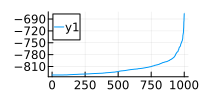

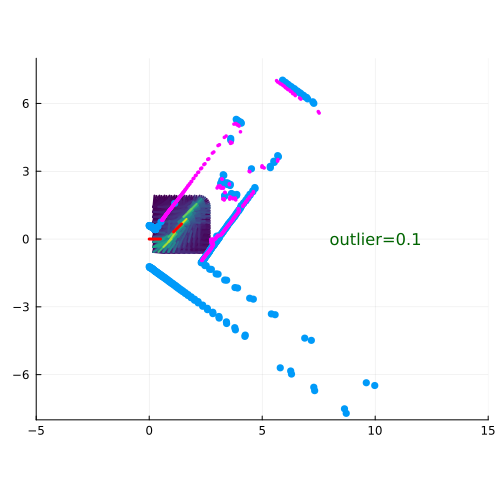

In [150]:
t = 1060
s = 5

ux  = sum([u.dx  for u in _us[t:t+s-1]])
uhd = sum([u.dhd for u in _us[t:t+s-1]])
u = Control( rot(-_hds[t])*ux, uhd)


p   = Pose(u.dx, u.dhd)
dx  = 1.
dhd = 45/360*2π
k   = 10

ps_ = pose_grid(p, k, dx, dhd)
ps  = [Pose(Vector(v)) for v in eachrow(Array(ps_))]

ys_ = CuArray(stack(_ys[t]))
x   = stack(_ys[t+s])


s_noise = 0.05
outlier = 1e-1
outlier_vol = 1.0
w = 20

q, log_q, (ps, log_ps) = grid_proposal(p, x, k, dx, dhd, ys_, as_, w, s_noise, outlier, outlier_vol)


perm  = sortperm(log_ps)
log_ps = log_ps[perm]
ps    = ps[perm]

cs = cgrad(:viridis)[peak_to_peak(log_ps)]
# -----------------------------
display(plot(log_ps, size=(200,100)))
mypl = plot(size=(500,500), legend=nothing, aspect_ratio=:equal, 
    xlim=(-5,15), ylim=(-8,8)
)

plot!(Pose.(ps), cs; r=.5, linewidth=2)
scatter!(_ys[t], markerstrokewidth=0, c=col[1], markersize=4)
scatter!(_ys[t+s] .* Pose(ps[end]), markerstrokewidth=0, c=:magenta, markersize=2)

plot!(Pose(), c=:red, r=.5, linewidth=3)
plot!(q, c=:red, r=.5, linewidth=3)

annotate!(10, 0, text("outlier=$(outlier)", :darkgreen, :center, 11))

mypl

### Iterated Proposal

In [ ]:
#nbx
@gen function iterated_proposal(p::Pose, x::Matrix, 
                                grid_k, grid_dx, grid_dhd,
                                ys_, as_, 
                                w, s_noise, outlier, outlier_vol)
    
    n = length(w)
    
    ps = Pose[p]
    Ls = []
    log_ps = [] 
    for i=1:n
        args = (
            p, x, 
            grid_k[i], grid_dx[i], grid_dhd[i],
            ys_, as_, 
            w[i], s_noise[i], outlier[i], outlier_vol[i])
        
        p, log_p, (_, ls) = {i} ~ grid_proposal(args...)
        push!(ps, p)
        push!(log_ps, log_p)
        push!(Ls, ls)
    end
    
    return ps[end], log_ps[end], ps, log_ps, Ls
end;

In [ ]:
using LinearAlgebra: norm

In [ ]:
# t = 1_160
t = 1_060
s = 5

ux  = sum([u.dx  for u in _us[t:t+s-1]])
uhd = sum([u.dhd for u in _us[t:t+s-1]])
u = Control( rot(-_hds[t])*ux, uhd)

p_ref = Pose()

# p = Pose(p_ref.x + u.dx, p_ref.hd+ u.dhd)
p = Pose(u.dx, u.dhd) * p_ref

x  = stack(_ys[t+s])
y  = stack(_ys[t] .* p_ref)
y[isnan.(y)] .= Inf
m_ = CuArray(y)

# Proposal args


n = 3

k   = fill(9, n)
dx  = 1.5 ./ (k*0.75) .^ collect(range(0,n-1))
dhd = 25/360*2π ./ (k*0.75) .^ collect(range(0,n-1))

s_noise     = fill(0.05, n)
outlier     = fill(1e-6, n)
outlier_vol = fill(1., n)
w           = fill(10, n)

grid_args = (k, dx, dhd, m_, as_, w, s_noise, outlier, outlier_vol)

ms = @elapsed q, log_q, ps, log_ps, = iterated_proposal(p, x, grid_args...);
ms = ms*1000

# -----------------------------
display(plot(log_ps, size=(200,100)))
mypl = plot(size=(500,500), legend=nothing, aspect_ratio=:equal, 
    xlim=(-5,20), ylim=(-8,8)
)

scatter!(_ys[t] .* p_ref, markerstrokewidth=0, c=col[1], markersize=4)
scatter!(_ys[t+s] .* q, markerstrokewidth=0, c=:magenta, markersize=2)

plot!(Pose(), c=:red, r=.5, linewidth=3)
plot!(q, c=:red, r=.5, linewidth=3)

annotate!(10, 0, text("$(nice_f(ms)) ms\noutlier=$(outlier[1])", :darkgreen, :left, 11))

mypl

## SLAM - Odometry only

In [ ]:
p_ref = Pose()

ps = Pose[]
xs = []
ts = []
times = []


for i=1:30

    s = 4
#     t = 1_050 + i*s
    t = 1_110 + i*s


    ux  = sum([u.dx  for u in _us[t:t+s-1]])
    uhd = sum([u.dhd for u in _us[t:t+s-1]])
    u = Control( rot(-_hds[t])*ux, uhd)

    p = Pose(u.dx, u.dhd)

    x  = stack(_ys[t+s])
    m_ = CuArray(stack(_ys[t]))

    # Proposal args


    n = 3

    k   = fill(10, n)
    dx  = 1. ./ (k*0.9) .^ collect(range(0,n-1))
    dhd = 25/360*2π ./ (k*0.9) .^ collect(range(0,n-1))

    s_noise     = fill(0.05, n)
    outlier     = fill(1e-9, n)
    outlier_vol = fill(1., n)
    w           = fill(20, n)

    grid_args = (k, dx, dhd, m_, as_, w, s_noise, outlier, outlier_vol)

    ms = @elapsed q, = iterated_proposal(p, x, grid_args...);
    ms = ms*1000
    ms = Int(floor(ms*100))/100
    
        
    push!(times, ms)
    push!(ps, q*p_ref)
    push!(xs, _ys[t+s])
    push!(ts, t)    
    p_ref = q*p_ref
end

println("""
Total:    $(sum(times)) ms
Avg step: $(mean(times)) ms
""")
length(ts), length(ps)

In [ ]:
FPS = Int(floor(1000/mean(times)))

In [ ]:
mypl = plot(aspect_ratio=:equal, legend=nothing, title="Odometry only")
plot!(ps, c=:red)
for (x,p) in zip(xs, ps)
    scatter!(x.*p, markersize=1, markerstrokewidth=0, c=col[1])
end
mypl

In [ ]:
NaN == NaN

## SLAM 

In [ ]:
1_050 + 220*s

Total:    12239.719999999998 ms
Avg step: 55.6350909090909 ms



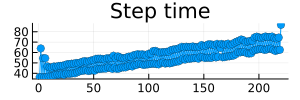

In [160]:
p_ref = Pose()

ps = Pose[]
log_ps = []
xs = []
ys = []
ts = []
times = []

t1 = 1_000
s  = 4


yy = []
for i=1:220

    t = t1 + i*s


    ux  = sum([u.dx  for u in _us[t:t+s-1]])
    uhd = sum([u.dhd for u in _us[t:t+s-1]])
    u = Control( rot(-_hds[t])*ux, uhd)

    p = Pose(u.dx,u.dhd)*p_ref

    x  = stack(_ys[t+s])
    
    yy = [yy; _ys[t] .* p_ref]
    y = stack(yy)
#     y = stack( _ys[t] )
    
    y[isnan.(y)] .= Inf
    
    m_ = CuArray(y)

    # Proposal args


    n = 3

    k   = fill(12, n)
    dx  = 1. ./ (k*0.7) .^ collect(range(0,n-1))
    dhd = 35/360*2π ./ (k*0.7) .^ collect(range(0,n-1))

    s_noise     = fill(0.05, n)
    outlier     = fill(1e-9, n)
#     s_noise     = range(0.1, 0.05, n)
#     outlier     = range(1e-1,1e-6,n)
    outlier_vol = fill(1., n)
    w           = fill(20, n)

    grid_args = (k, dx, dhd, m_, as_, w, s_noise, outlier, outlier_vol)

    ms = @elapsed q, log_q, = iterated_proposal(p, x, grid_args...);
    ms = ms*1000
    ms = Int(floor(ms*100))/100
        
    push!(times, ms)
    push!(ps, q)
    push!(log_ps, log_q)
    push!(ys, _ys[t] .* p_ref)
    push!(xs, _ys[t+s])
    push!(ts, t)    
    p_ref = q
    
    
end

println("""
Total:    $(sum(times)) ms
Avg step: $(mean(times)) ms
""")
length(ts), length(ps)
plot(times, size=(300,100), marker=:o, title="Step time", legend=nothing)

79420


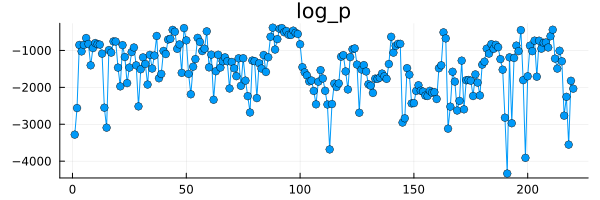

In [161]:
println(length(yy))
plot(log_ps, size=(600,200), marker=:o, title="log_p", legend=nothing)

In [162]:
FPS = Int(floor(1000/mean(times)))

17

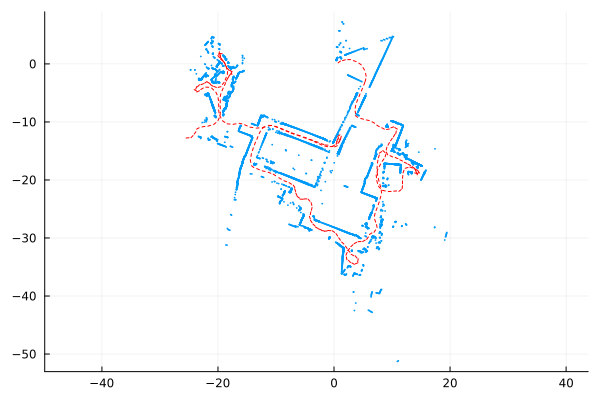

In [163]:
mypl = plot(aspect_ratio=:equal, legend=nothing)


plot!(ps[1:end], c=:red)
for (t,(x,p)) in enumerate(zip(xs[1:10:end], ps[1:10:end]))
    scatter!(x.*p, markersize=1, markerstrokewidth=0, c=col[1], alpha=1.)
end

mypl

In [104]:
length(ps)

220

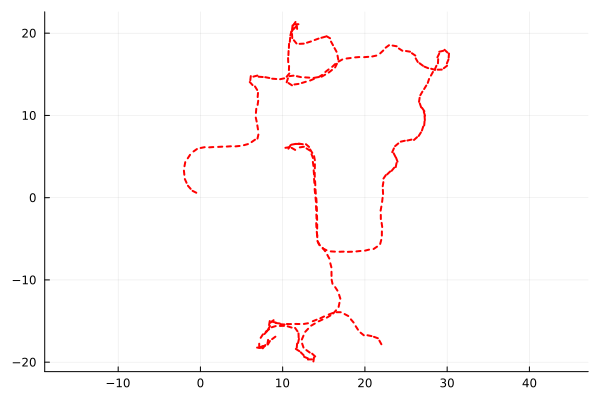

In [105]:
mypl = plot(size=(600,400),aspect_ratio=:equal, legend=nothing, 
#     xlim=(-35,25), 
#     ylim=(-25,5)
)
pp = Pose(0,0,115/360*2π)
plot!([p * pp for p in ps], c=:red, linewidth=2, alpha=1)

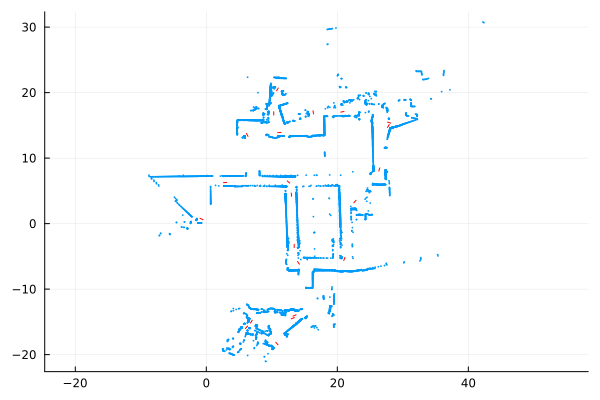

In [126]:
t=100
mypl = plot(size=(600,400),aspect_ratio=:equal, legend=nothing, 
#     xlim=(-35,25), 
#     ylim=(-35,5)
)

pp = Pose(0,0,115/360*2π)
for (x,p) in zip(xs[1:10:end], ps[1:10:end])


    plot!([p*pp], c=:red, alpha=1,linewidth=1,)

    scatter!(x.*(p*pp), markersize=1, markerstrokewidth=0, c=col[1], alpha=1.)
end

mypl

In [127]:
qs = [p*pp for p in ps];

In [128]:
length(ps)

220

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/slam_csail.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/slam_csail.gif")
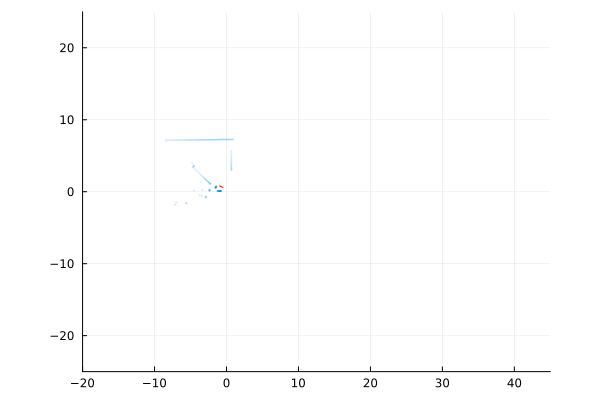

In [129]:
ani = Animation()

for t=1:20:length(ps)
    mypl = plot(size=(600,400),aspect_ratio=:equal, legend=nothing, 
        xlim=(-20,45), 
        ylim=(-25,25))
    
    for (i,x,p) in zip(1:t, xs[1:t], qs[1:t])
        delta = 20
        i_ = 1/delta*(i - t + delta)
        plot!([p], c=:red, alpha=max(i_,0)^2,linewidth=1,)
        
        scatter!(x.*p, markersize=1, markerstrokewidth=0, c=col[1], alpha=0.1)
    end
    frame(ani, mypl)
end

gif(ani,"_imgs/slam_csail.gif", fps=FPS)

In [ ]:
1_000 / (FPS/4)